# Denoising Autoencoder

Maiah Pardo
August 5, 2021

Building a simple denoising autoencoder using the MNIST Fashion dataset.

In [ ]:
%matplotlib inline

In [ ]:
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist

# Data visualizaton.
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import random as rn
rn.seed(123)
np.random.seed(seed=123)

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
%matplotlib inline

4431872/4422102 [==============================] - 0s 0us/step


Getting the imports and downloading the dataset.

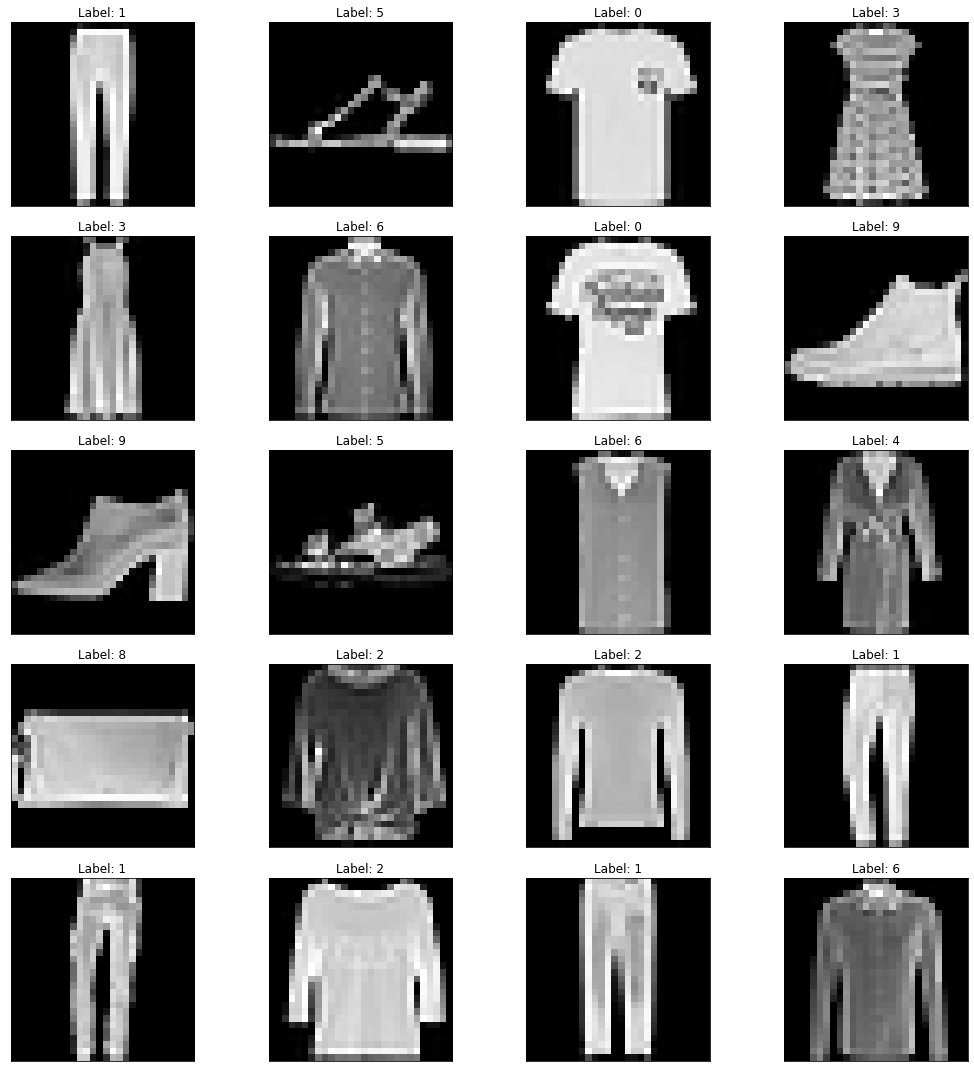

In [ ]:
# Plot some of the images from x_test
fig, ax = plt.subplots(5, 4)
fig.set_size_inches(15, 15)

for i in range(5):
    for j in range(4):
        l=rn.randint(0, len(y_test))
        ax[i, j].imshow(x_test[l], cmap='gray')
        ax[i, j].set_title('Label: ' + str(y_test[l]))
        # Hide grid lines
        ax[i, j].grid(False)
        # Hide axes ticks
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        
plt.tight_layout()

Adding noise to the images in boath x_train and x_test and then plotting some of the noisy images from x_train.

In [ ]:
def corrupt_pixel(image):
    """selects a certain number of pixels (between 50 and 100) and changes their value to 255"""
    num_pixels = np.random.randint(50,100)
    img = image.copy()

    for i in range(num_pixels):
        cell = np.random.randint(0,28,size = 2)
        img[cell[0]][cell[1]] = np.random.randint(125,255)
    return img

In [ ]:
# corrupt the images
x_train_noisy = [] #x_train with noise added
for image in x_train:
    x_train_noisy.append(corrupt_pixel(image))

x_test_noisy = [] #x_test with noise added
for image in x_test:
    x_test_noisy.append(corrupt_pixel(image))

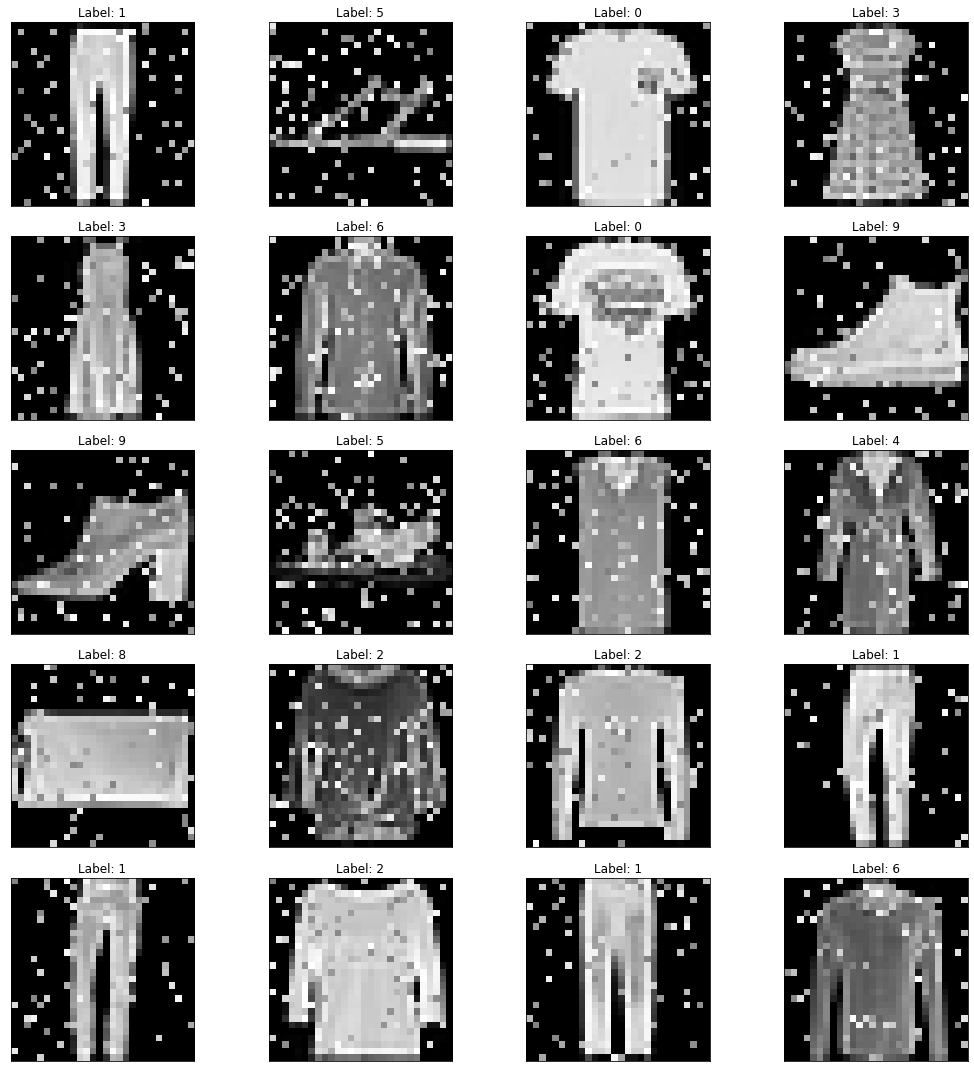

In [ ]:
# Replot some of the test images with noise added
rn.seed(123)
np.random.seed(seed=123)

fig, ax = plt.subplots(5, 4)
fig.set_size_inches(15, 15)

for i in range(5):
    for j in range(4):
        l=rn.randint(0, len(y_test))
        ax[i, j].imshow(x_test_noisy[l], cmap='gray')
        ax[i, j].set_title('Label: ' + str(y_test[l]))
        # Hide grid lines
        ax[i, j].grid(False)
        # Hide axes ticks
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        
plt.tight_layout()

We now have corrupted the images. Now we can build a denoising autoencoder to hopefully remove some of the noise. First, I will normalize the data and an extra dimension will be added to the images.

In [ ]:
# Scale X_train to 255. which is max
x_train  = np.array(x_train)/255.

# Reshape X_train to (N,28,28,1) for convolution layers
x_train = x_train.reshape(len(x_train),28,28,1)

# Scale X_test to 255. which is max
x_test  = np.array(x_test)/255.

# Reshape X_train to (N,28,28,1) for convolution layers
x_test = x_test.reshape(len(x_test),28,28,1)

# Scale X_train to 255. which is max
x_train_noisy  = np.array(x_train_noisy)/255.

# Reshape X_train to (N,28,28,1) for convolution layers
x_train_noisy = x_train_noisy.reshape(len(x_train_noisy),28,28,1)

# Scale X_test to 255. which is max
x_test_noisy  = np.array(x_test_noisy)/255.

# Reshape X_train to (N,28,28,1) for convolution layers
x_test_noisy = x_test_noisy.reshape(len(x_test_noisy),28,28,1)

Building the autoencoder.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras import backend as KB
from tensorflow.keras.layers import Reshape, Conv2DTranspose

# Network parameters
image_size = x_train.shape[1]
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
latent_dim = 16
# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# Build your model (Autoencoder: consists of encoder, decoder)

# Build the Encoder Model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# Stack of Conv2D blocks
# Note:
# Use Batch Normalization before ReLU on deep networks
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)


x = Conv2D(filters=12,
           kernel_size=kernel_size,
           strides=1,
           activation='relu',
           padding='same')(x)


# Shape info needed to build Decoder Model
shape = KB.int_shape(x)
#print(shape)

# Generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()
print('\n\n')



# Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Transposed Conv2D blocks

for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 12)          6924      
_________________________________________________________________
flatten (Flatten)            (None, 588)               0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                9424      
Total params: 35,164
Trainable params: 35,164
Non-trainable params: 0
_______________________________________________________

Training the autoencoder.
I use mean square error as my loss, and plot the training curve as well.

In [ ]:
# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()
print('\n\n')

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                35164     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         35725     
Total params: 70,889
Trainable params: 70,889
Non-trainable params: 0
_________________________________________________________________





In [ ]:
# Compile your model
#autoencoder.compile(loss='mse', optimizer='adam', metric=['accuracy'])
autoencoder.compile(loss='mse', optimizer='adam', metrics=['mse'])

# Train the autoencoder
history = autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=20,
                batch_size=batch_size)


Epoch 1/20
469/469 [==============================] - 82s 173ms/step - loss: 0.0392 - mse: 0.0392 - val_loss: 0.0196 - val_mse: 0.0196
Epoch 2/20
469/469 [==============================] - 83s 177ms/step - loss: 0.0175 - mse: 0.0175 - val_loss: 0.0160 - val_mse: 0.0160
Epoch 3/20
469/469 [==============================] - 83s 177ms/step - loss: 0.0153 - mse: 0.0153 - val_loss: 0.0148 - val_mse: 0.0148
Epoch 4/20
469/469 [==============================] - 83s 178ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 5/20
469/469 [==============================] - 82s 176ms/step - loss: 0.0138 - mse: 0.0138 - val_loss: 0.0137 - val_mse: 0.0137
Epoch 6/20
469/469 [==============================] - 83s 177ms/step - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0133 - val_mse: 0.0133
Epoch 7/20
469/469 [==============================] - 83s 177ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 8/20
469/469 [==============================] - 8

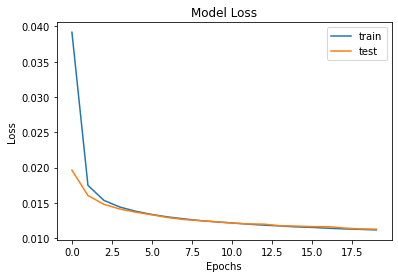

In [ ]:
# Plot the training curve for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

Plotting the "denoised" images from the test set.
Note: MSE error is known to smooth an image too much.

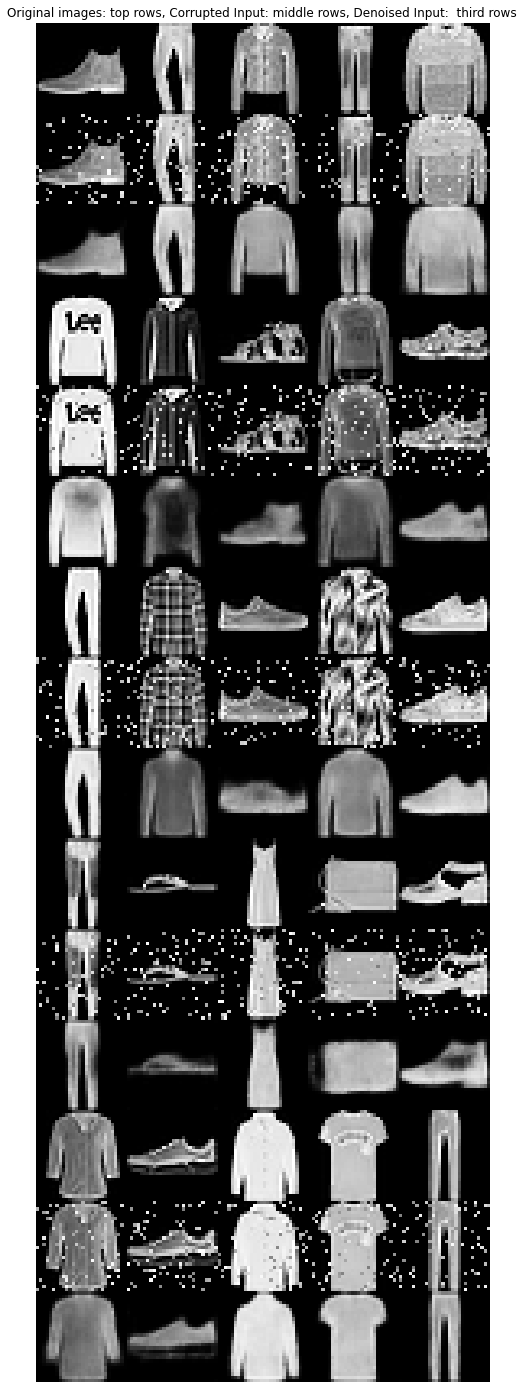

In [ ]:
# Plot images some of the "denoised" images from the test set

# Predict the Autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)
# Display the 1st 8 corrupted and denoised images
rows, cols = 5, 5
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure(figsize=(25, 25))
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.show()

Analysis:<br/>

The model did denoise all the images successfully, as there are no longer any obvious missing pixels (white dots) in the denoised images. The denoised images came out a little bit blurry. There were no unexpected results, as I did expect that the detail would get somewhat smoothed out compared to the originals. I did, however, lose most of the fine detail from the original images due to the MSE error smoothing the image too much, so the model did suffer from this. The blurriness was not so bad that it took away from being able to identify the object in the image. Overall, I think the model performed well at removing the noise from the images while keeping the objects in the image identifiable.